In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt
from imutils import face_utils
import os, cv2, dlib
import scipy.signal as signal
from scipy.ndimage import median_filter
import pandas as pd
from hdf5storage import loadmat, savemat

frameRate = 20 # fps of camera


sub = '105'
ses = '4'
hiDef = True # True if using high precision
baselineIndx = 1 * frameRate #seconds
varThresh = 3
time = np.arange(-1000,10500,50)
sub = '105'
ses = '4'
hiDef = False

def makefiltersos(sr,fp,fs,gp=3,gs=20):
	""" 	Wrapper function around scipy filter functions.  
	Makes it convenient by providing frequency parameters in terms of 
	frequencies in Hz.   
	INPUT: 	sr - sampling rate in Hz. 
		fp - pass frequency in Hz
		fs - stop frequency in Hz
		gp - pass band ripple in dB, default 3 dB
		gs - stop band attenuation in dB, default 20 dB
		doPlot - make a plot of filter gain versus frequency, default 'no'
	OUTPUT: sos filter coefficients. 
			w,h for making bode plot 
	Automatically detects the type of filter.  if fp < fs the filter
	is low pass but if fp > fs the filter is highpass.  """
#
#set up filter parameters

	fn = sr/2
	wp = fp/fn
	ws = fs/fn
#get the filter order

	n,wn = signal.buttord(wp,ws,gp,gs);                                                            
#design the filter

#lowpass 
	if fp < fs:
		sos = signal.butter(n,wn,btype='lowpass',output='sos')
#highpass
	if fs < fp:
		sos = signal.butter(n,wn,btype='highpass',output='sos')
#get filter respons function	
	w,h = signal.sosfreqz(sos,fs=sr)
	return sos,w,h

def makeDummy(arr,mask):
    prac = []
    for i,j in zip(arr,mask):
        if j:
            prac.append(np.full_like(i,0))
        else:
            prac.append(i)
    return np.array(prac)

def getOutlier(roi_data,mask,varThresh):
    roi_data = makeDummy(roi_data,mask)
    # totalImages = len(roi_data)
    # trial_labeling = np.arange(0,len(roi_data))
    trialsVar = np.var(roi_data, axis = 1)
    stdTrials = np.std(trialsVar)
    medianVarTrials = np.median(trialsVar)
    trialOutlier = np.where(trialsVar > medianVarTrials + varThresh * stdTrials)[0]
    return trialsVar,stdTrials,medianVarTrials,trialOutlier

def removeOutlier(roi_data, invalidTrials,baselineIndx):
    trial_labeling = np.arange(0,len(roi_data))

    maskVarOutlier = ~np.isin(np.arange(roi_data.shape[0]), invalidTrials)
    trial_labeling_outlier_removed = trial_labeling[maskVarOutlier]
    # print(f'Data decreased from {len(trial_labeling)} to {len(trial_labeling_outlier_removed)}')

    roi_data_outlier_removed = roi_data[maskVarOutlier].copy()

    # plt.plot(np.mean(roi_data_outlier_removed, axis = 0) - np.mean(roi_data_outlier_removed[:, :baselineIndx]))
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('MeanTemperature (Baselined)')
    # plt.show()

    # plt.plot(roi_data_outlier_removed.T - np.mean(roi_data_outlier_removed[:, :baselineIndx]).T)
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('Temperature Trials (Baselined)')
    # plt.show()

    return roi_data_outlier_removed

def plotCleanup(trialsVar,medianVarTrials,stdTrials,varThresh = 3):
    plt.scatter(np.linspace(0, trialsVar.shape[0] - 1, trialsVar.shape[0]), trialsVar)
    plt.hlines(medianVarTrials + varThresh * stdTrials, 0, trialsVar.shape[0], colors="red")
    plt.ylabel('Variance')
    plt.xlabel('Trial')
    plt.title('Total variance in trial')
    plt.show()
    
def baselinecorrect(data,baselinesamps):
    base = np.mean(data[:,baselinesamps],axis = 1)
    print(data.shape)
    print(base.shape)
    nrows = np.size(data,axis=0)
    ncols = np.size(data,axis=1)
    databc = np.zeros((nrows,ncols))
    for j in range(nrows):
        databc[j,:] = data[j,:] - base[j]
    return databc

# def baselinecorrect(data,baselinesamps):
# 	""" 	Corrects for baseline offset in evoked potentials    
# 	INPUT: 	data is the data 
# 			baselinesamps is the indices of the samples to use as a baseline
# 			e.g., range(200)
# 	OUTPUT: databc baseline corrected data 
# 	Automatically calculates the mean of the baseline interval
# 	and then removes it from the timeseries """
# #
# #find the mean 
# 	base = np.mean(data[baselinesamps,:],axis = 0)
# 	nrows = np.size(data,axis = 0)	
# 	ncols = np.size(data,axis = 1)	
# 	databc = np.zeros((nrows,ncols))
# 	for j in range(ncols):
# 		databc[:,j] = data[:,j] - base[j]
# 	return databc



In [2]:
path = f'../../thermal/Shane/Subject{sub}/{sub}Session{ses}/'

segmentData = loadmat(f'segmented/{sub}SS{ses}_segmented.hdf')
responsechoice = segmentData['choice']
stimresponsechoice = segmentData['pk_choice']
eegBadTrials = list(set(np.where(responsechoice == -1)[0]) | set(np.where(stimresponsechoice == -1)[0]))
mask = np.array([True if i in eegBadTrials else False for i in np.arange(298)])

In [3]:
detector = dlib.simple_object_detector(os.path.join("models/", "dlib_face_detector.svm"))
predictor = dlib.shape_predictor(os.path.join("models/", "dlib_landmark_predictor.dat"))

Logic for making region around ROI

In [4]:
keep_nose_roi_data = []
keep_forehead_roi_data = []
keep_left_cheek_roi_data = []
keep_right_cheek_roi_data = []
keep_bridge_roi_data = []
keep_room_temp_data = []
keepEegBadTrials = []

pass_nose_roi_data = []
pass_forehead_roi_data = []
pass_left_cheek_roi_data = []
pass_right_cheek_roi_data = []
pass_bridge_roi_data = []
pass_room_temp_data = []
passEegBadTrials = []

full_nose_roi_data = []
full_forehead_roi_data = []
full_left_cheek_roi_data = []
full_right_cheek_roi_data = []
full_bridge_roi_data = []
full_room_temp_data = []


full_eye_blinks = []

window_size = 15

# for nback task
# blocks = 10
# levels = 3

# for shanes thing?
numTrials = 300
# numTrials = 75
# images = 145
def fixEnd(arr):
    goodInd = 0
    for i,j in enumerate(arr):
        if j == 0:
            arr[i] = arr[goodInd]
        else:
            goodInd = i
    return arr

def extractWindow(region,window_size,thermalImages):
    rois = []
    for i,point in enumerate(region):
        if not np.all(point == 0):  # Skip if the point is [0, 0], indicating no face found
            roi_x = int(point[0]) - window_size // 2
            roi_y = int(point[1]) - window_size // 2
            # Apply a 5x5 median filter to smooth the image
            # smoothed_image = median_filter(thermalImages[i, :, :], size=(5,5))
            # roi = smoothed_image[roi_y:roi_y + window_size, roi_x:roi_x + window_size]
            roi = thermalImages[i, roi_y:roi_y + window_size, roi_x:roi_x + window_size]
        else:
            roi = np.zeros((window_size, window_size))  # Placeholder for no face

        rois.append(roi)

    rois = np.array(rois)
    timeseries = rois[:, :, :].mean(axis = (1, 2))

    return timeseries
    
# changed structure for shane
try:
    for trial in range(numTrials):
        title = 'Trial:' + str(trial)
    
        timeStamp = np.load(path + 'timeStamp/timeStampBlocktrial' + str(trial) + '.npy')
        timeStamp =  timeStamp / 10000000
        totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        collectedFrames = totalFrames - np.sum(timeStamp == 0)
        # print(collectedFrames)
        if hiDef:
            thermalImages = np.load(path + 'images/imagesBlocktrial' + str(trial) + '.npy')/ 100 - 100 # 100 - 100 for high precision; 10 - 100 for low precision
        else:
            thermalImages = np.load(path + 'images/imagesBlocktrial' + str(trial) + '.npy')/ 10 - 100 # 100 - 100 for high precision; 10 - 100 for low precision
        thermalImages = thermalImages.reshape(-1, 288, 382)
    
        # collectedFrames = totalFrames - np.sum(timeStamp == 0)
        if collectedFrames < 160:
            images = 148
        elif collectedFrames < 230:
            images = 215
        
        left_brow = np.zeros([images, 2])
        right_brow = np.zeros([images, 2])
        nose_tip = np.zeros([images, 2])
        nose_bridge = np.zeros([images,2])
        left_cheek = np.zeros([images, 2])
        right_cheek = np.zeros([images, 2])
        left_eye = np.zeros([images,2])
        right_eye = np.zeros([images,2])
        left_corner = np.zeros([images, 2])
        right_corner = np.zeros([images, 2])
        print(title)
        
        # timeStamp = np.load(path + str(trial) + '.npy')
    
        # timeStamp =  timeStamp / 10000000
        # totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        # collectedFrames = totalFrames - np.sum(timeStamp == 0)
        
    
        print('Total images in trial:', collectedFrames)
        
        for currentImage in range(images):
            thermalImage = thermalImages[currentImage, :, :]
            # min_temp = np.partition(x, 1)[0:2]
            # max_temp = 
            min_temp = np.min(thermalImage)
            max_temp = np.max(thermalImage)
    
            normalized_thermal_image = ((thermalImage - min_temp) / (max_temp - min_temp) * 255).astype(np.uint8)       
            rects = detector(normalized_thermal_image, upsample_num_times=1)
    
            if rects:
                # for i, (sx, sy) in enumerate(shape):
                #     coord = [int(sx), int(sy)]
                # #     rx1 = int(sx) - window_size // 2
                # #     ry1 = int(sy) - window_size // 2
                # #     c1 = (rx1,ry1)
                # #     c2 = (rx1+window_size,ry1+window_size)
                #     cv2.circle(normalized_thermal_image, coord, 2, (0, 255, 0), -1)  # -1 for a filled circle
                (x, y, w, h) = face_utils.rect_to_bb(rects[0])
                shape = predictor(normalized_thermal_image, rects[0])
                shape = face_utils.shape_to_np(shape)

                # left brow
                coord = [int(shape[21][0]), int(shape[21][1])]
                left_brow[currentImage, :] = np.array(coord)
                lx = int(shape[21][0])
                ly = int(shape[21][1])

                # right brow
                coord = [int(shape[22][0]), int(shape[22][1])]
                right_brow[currentImage, :] = np.array(coord)
                rx = int(shape[22][0])
                ry = int(shape[22][1])
                bx = int((lx + rx) / 2) - window_size // 2
                by = int((ly + ry) / 2) - 5 * window_size // 4
                c1 = (bx,by)
                c2 = (bx+window_size,by+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # nose bridge
                coord = [int(shape[28][0]), int(shape[28][1])]
                nose_bridge[currentImage, :] = np.array(coord)
                nx = int(shape[28][0]) - window_size // 2
                ny = int(shape[28][1]) - window_size // 2
                c1 = (nx,ny)
                c2 = (nx+window_size,ny+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # nose
                coord = [int(shape[30][0]), int(shape[30][1])]
                nose_tip[currentImage, :] = np.array(coord)
                nx = int(shape[30][0]) - window_size // 2
                ny = int(shape[30][1]) - window_size // 2
                c1 = (nx,ny)
                c2 = (nx+window_size,ny+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))
            
                # left cheek
                # cv2.rectangle(normalized_thermal_image,(shape[5][0],shape[31][1]),(shape[48][0],shape[30][1]),(0, 0, 255))
                lchk = [int((shape[5][0] + shape[48][0])/2),int((shape[33][1] + shape[30][1])/2)]
                left_cheek[currentImage,:] = np.array(lchk)
                c1 = (lchk[0] - window_size//2, lchk[1] - window_size//2)
                c2 = (c1[0]+window_size, c1[1]+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # right cheek
                # cv2.rectangle(normalized_thermal_image,(shape[11][0],shape[31][1]),(shape[50][0],shape[30][1]),(0, 0, 255))
                rchk = [int((shape[11][0] + shape[50][0])/2),int((shape[33][1] + shape[30][1])/2)]
                right_cheek[currentImage,:] = np.array(rchk)
                c1 = (rchk[0] - window_size//2, rchk[1] - window_size//2)
                c2 = (c1[0]+window_size, c1[1]+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # left eye
                pts = np.array([shape[36:42]],
                   np.int32)
                pts = pts.reshape((-1, 1, 2))
                x = [j[0] for i in pts for j in i]
                y = [j[1] for i in pts for j in i]
                le = [int(np.mean(x)),int(np.mean(y))]
                left_eye[currentImage,:] = np.array(le)
                cv2.circle(normalized_thermal_image, le, 2, (0, 0, 255), -1)
    
                # right eye
                pts = np.array([shape[42:48]],
                   np.int32)
                pts = pts.reshape((-1, 1, 2))
                x = [j[0] for i in pts for j in i]
                y = [j[1] for i in pts for j in i]
                re = [int(np.mean(x)),int(np.mean(y))]
                right_eye[currentImage,:] = re
                cv2.circle(normalized_thermal_image, re, 2, (0, 0, 255), -1)

                # left corner
                c1 = (0,0)
                c2 = (20,20)
                lcoord = [int((c1[0]+c2[0])/2),int((c1[1]+c2[1])/2)]
                cv2.circle(normalized_thermal_image, lcoord, 2, (0, 255, 0), -1)  # -1 for a filled circle
                left_corner[currentImage, :] = np.array(lcoord)

                # right corner
                c1 = (382,0)
                c2 = (362,20)
                rcoord = [int((c1[0]+c2[0])/2),int((c1[1]+c2[1])/2)]
                cv2.circle(normalized_thermal_image, rcoord, 2, (0, 255, 0), -1)  # -1 for a filled circle
                right_corner[currentImage, :] = np.array(rcoord)
    
            else:
                print("dlib found no face")  
                ### try using previous?
    
            cv2.imshow('Image with Points', normalized_thermal_image)
            cv2.waitKey(1)
    
        nose_timeseries = extractWindow(nose_tip,window_size,thermalImages)
        bridge_timeseries = extractWindow(nose_bridge,window_size,thermalImages)
        forehead_timeseries = extractWindow((left_brow + right_brow)/2,window_size,thermalImages)
        left_cheek_timeseries = extractWindow(left_cheek,window_size,thermalImages)
        right_cheek_timeseries = extractWindow(right_cheek,window_size,thermalImages)
        left_eye_timeseries = extractWindow(left_eye,1,thermalImages)
        right_eye_timeseries = extractWindow(right_eye,1,thermalImages)
        right_corner_timeseries = extractWindow(right_corner,20,thermalImages)
        left_corner_timeseries = extractWindow(left_corner,20,thermalImages)
        room_timeseries = (right_corner_timeseries+left_corner_timeseries)/2

        if 0 in room_timeseries:
            nose_timeseries = fixEnd(nose_timeseries)
            bridge_timeseries = fixEnd(bridge_timeseries)
            forehead_timeseries = fixEnd(forehead_timeseries)
            left_cheek_timeseries = fixEnd(left_cheek_timeseries)
            right_cheek_timeseries = fixEnd(right_cheek_timeseries)
            left_eye_timeseries = fixEnd(left_eye_timeseries)
            right_eye_timeseries = fixEnd(right_eye_timeseries)
            right_corner_timeseries = fixEnd(right_corner_timeseries)
            left_corner_timeseries = fixEnd(left_corner_timeseries)
            room_timeseries = (right_corner_timeseries+left_corner_timeseries)/2

        
        if images == 148:
            if trial in eegBadTrials:
                keepEegBadTrials.append(True)
            else:
                keepEegBadTrials.append(False)
            keep_nose_roi_data.append(nose_timeseries)
            keep_bridge_roi_data.append(bridge_timeseries)
            keep_forehead_roi_data.append(forehead_timeseries)
            keep_left_cheek_roi_data.append(left_cheek_timeseries)
            keep_right_cheek_roi_data.append(right_cheek_timeseries)
            keep_room_temp_data.append(room_timeseries)

    
        elif images == 215:
            if trial in eegBadTrials:
                passEegBadTrials.append(True)
            else:
                passEegBadTrials.append(False)
            pass_nose_roi_data.append(nose_timeseries)
            pass_bridge_roi_data.append(bridge_timeseries)
            pass_forehead_roi_data.append(forehead_timeseries)
            pass_left_cheek_roi_data.append(left_cheek_timeseries)
            pass_right_cheek_roi_data.append(right_cheek_timeseries)
            pass_room_temp_data.append(room_timeseries)
    
        full_nose_roi_data.append(nose_timeseries)
        full_bridge_roi_data.append(bridge_timeseries)
        full_forehead_roi_data.append(forehead_timeseries)
        full_left_cheek_roi_data.append(left_cheek_timeseries)
        full_right_cheek_roi_data.append(right_cheek_timeseries)
        full_room_temp_data.append(room_timeseries)
    
        # full_eye_blinks.append(eye_timeseries)
        # plt.plot(left_eye_timeseries)
        # plt.plot(right_eye_timeseries)
        # plt.plot((left_eye_timeseries + right_eye_timeseries)/2)
        # plt.title(title+' -Eye Mean')
        # plt.show()
    
        # plt.plot((left_eye_timeseries + right_eye_timeseries)/2,label='Eye')
        # # plt.plot(,label='R Eye')
        # plt.plot(bridge_timeseries,label = 'Bridge')
        # plt.plot(nose_timeseries, label = 'Nose')
        # # plt.plot()
        # # plt.ylim(0.5,1)
        # # plt.title(title + ' - Nose')
        # # plt.show()
        
        # plt.plot(forehead_timeseries,label = 'Forehead')
        # # plt.title(title + ' - Forehead')
        # # plt.show()
    
        # # plt.plot(left_cheek_timeseries,label='left')
        # # plt.plot(right_cheek_timeseries,label='right')
        # # plt.legend()
        # plt.plot((left_cheek_timeseries+right_cheek_timeseries)/2,label = 'Cheeks')
        # # plt.title(title + ' - Cheeks')
        # # plt.show()
        # plt.title(title)
        # plt.legend()
        # plt.show()
except FileNotFoundError:
    print(f'Ended at {trial}')
    
cv2.destroyAllWindows()



Trial:0
Total images in trial: 148
Trial:1
Total images in trial: 148
Trial:2
Total images in trial: 148
Trial:3
Total images in trial: 148
Trial:4
Total images in trial: 148
Trial:5
Total images in trial: 148
Trial:6
Total images in trial: 152
Trial:7
Total images in trial: 155
Trial:8
Total images in trial: 155
Trial:9
Total images in trial: 223
Trial:10
Total images in trial: 156
Trial:11
Total images in trial: 155
Trial:12
Total images in trial: 148
Trial:13
Total images in trial: 148
Trial:14
Total images in trial: 148
Trial:15
Total images in trial: 213


<ipython-input-4-a82a9ce245a7>:116: RuntimeWarning: invalid value encountered in true_divide
  normalized_thermal_image = ((thermalImage - min_temp) / (max_temp - min_temp) * 255).astype(np.uint8)


dlib found no face
dlib found no face
Trial:16
Total images in trial: 149
Trial:17
Total images in trial: 155
Trial:18
Total images in trial: 155
Trial:19
Total images in trial: 155
Trial:20
Total images in trial: 219
Trial:21
Total images in trial: 148
Trial:22
Total images in trial: 147
dlib found no face
Trial:23
Total images in trial: 148
Trial:24
Total images in trial: 149
Trial:25
Total images in trial: 220
Trial:26
Total images in trial: 155
Trial:27
Total images in trial: 222
Trial:28
Total images in trial: 148
Trial:29
Total images in trial: 213
dlib found no face
dlib found no face
Trial:30
Total images in trial: 148
Trial:31
Total images in trial: 218
Trial:32
Total images in trial: 155
Trial:33
Total images in trial: 155
Trial:34
Total images in trial: 155
Trial:35
Total images in trial: 212
dlib found no face
dlib found no face
dlib found no face
Trial:36
Total images in trial: 147
dlib found no face
Trial:37
Total images in trial: 147
dlib found no face
Trial:38
Total ima

In [5]:
##Use this if you messed up hte conversion
## change to low-def
def convertToLow(arr):
    return [((i + 100) * 100)/ 10 - 100 for i in arr]

# keep_nose_roi_data = convertToLow(keep_nose_roi_data)
# keep_bridge_roi_data = convertToLow(keep_bridge_roi_data)
# keep_forehead_roi_data = convertToLow(keep_forehead_roi_data)
# keep_left_cheek_roi_data = convertToLow(keep_left_cheek_roi_data)
# keep_right_cheek_roi_data = convertToLow(keep_right_cheek_roi_data)
# keep_room_temp_data = convertToLow(keep_room_temp_data)

# pass_nose_roi_data = convertToLow(pass_nose_roi_data)
# pass_bridge_roi_data = convertToLow(pass_bridge_roi_data)
# pass_forehead_roi_data = convertToLow(pass_forehead_roi_data)
# pass_left_cheek_roi_data = convertToLow(pass_left_cheek_roi_data)
# pass_right_cheek_roi_data = convertToLow(pass_right_cheek_roi_data)
# pass_room_temp_data = convertToLow(pass_room_temp_data)

# full_nose_roi_data = convertToLow(full_nose_roi_data)
# full_bridge_roi_data = convertToLow(full_bridge_roi_data)
# full_forehead_roi_data = convertToLow(full_forehead_roi_data)
# full_left_cheek_roi_data = convertToLow(full_left_cheek_roi_data)
# full_right_cheek_roi_data = convertToLow(full_right_cheek_roi_data)
# full_room_temp_data = convertToLow(full_room_temp_data)
## change to hi-def
def convertToLow(arr):
    return [((i + 10) * 100)/ 100 - 100 for i in arr]

# keep_nose_roi_data = convertToLow(keep_nose_roi_data)
# keep_bridge_roi_data = convertToLow(keep_bridge_roi_data)
# keep_forehead_roi_data = convertToLow(keep_forehead_roi_data)
# keep_left_cheek_roi_data = convertToLow(keep_left_cheek_roi_data)
# keep_right_cheek_roi_data = convertToLow(keep_right_cheek_roi_data)
# keep_room_temp_data = convertToLow(keep_room_temp_data)

# pass_nose_roi_data = convertToLow(pass_nose_roi_data)
# pass_bridge_roi_data = convertToLow(pass_bridge_roi_data)
# pass_forehead_roi_data = convertToLow(pass_forehead_roi_data)
# pass_left_cheek_roi_data = convertToLow(pass_left_cheek_roi_data)
# pass_right_cheek_roi_data = convertToLow(pass_right_cheek_roi_data)
# pass_room_temp_data = convertToLow(pass_room_temp_data)

# full_nose_roi_data = convertToLow(full_nose_roi_data)
# full_bridge_roi_data = convertToLow(full_bridge_roi_data)
# full_forehead_roi_data = convertToLow(full_forehead_roi_data)
# full_left_cheek_roi_data = convertToLow(full_left_cheek_roi_data)
# full_right_cheek_roi_data = convertToLow(full_right_cheek_roi_data)
# full_room_temp_data = convertToLow(full_room_temp_data)

3.445777777777721 5.1928888888890015 -5.037333333333436 -4.120444444444502 4.303111111111093


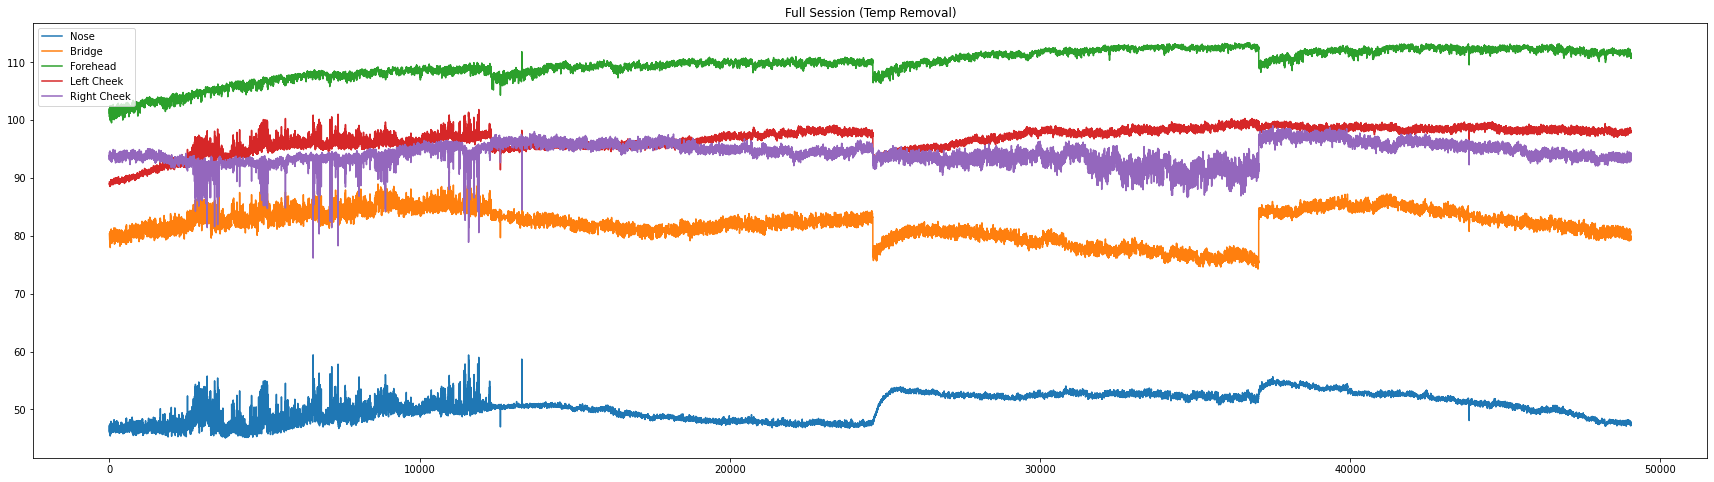

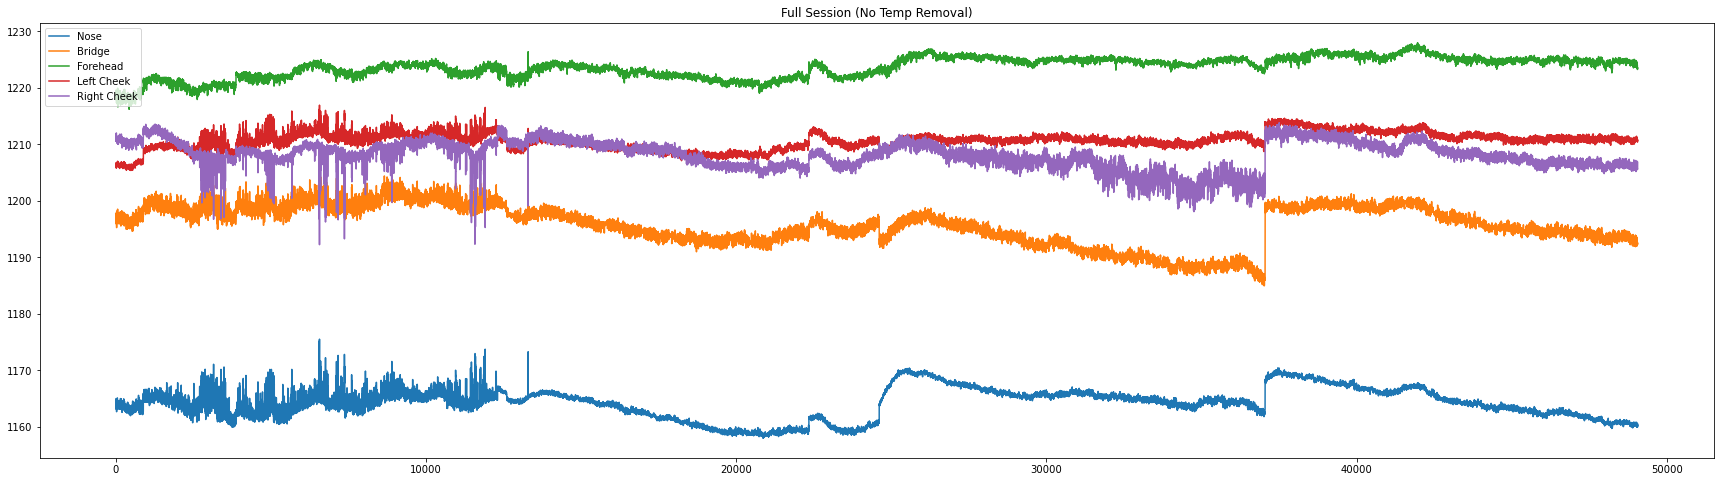

In [6]:
from scipy import ndimage
fullNose = [j for i in full_nose_roi_data for j in i]
fullBridge = [j for i in full_bridge_roi_data for j in i]
fullForehead = [j for i in full_forehead_roi_data for j in i]
fullLeftCheek = [j for i in full_left_cheek_roi_data for j in i]
fullRightCheek = [j for i in full_right_cheek_roi_data for j in i]
fullRoom = np.array([j for i in full_room_temp_data for j in i])
print(fullNose[0] - fullNose[-1]
    , fullBridge[0] - fullBridge[-1]
    , fullForehead[0] - fullForehead[-1]
    , fullLeftCheek[0]-fullLeftCheek[-1]
    , fullRightCheek[0]-fullRightCheek[-1])
# s1ts,s2ts,s3ts,s4ts
plt.figure(figsize=(30,8))
plt.plot(fullNose-fullRoom,label='Nose')
plt.plot(fullBridge-fullRoom,label='Bridge')
plt.plot(fullForehead-fullRoom,label='Forehead')
plt.plot(fullLeftCheek-fullRoom,label='Left Cheek')
plt.plot(fullRightCheek-fullRoom,label='Right Cheek')
plt.title('Full Session (Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],tmin,tmax)
plt.show()
plt.figure(figsize=(30,8))
plt.plot(fullNose,label='Nose')
plt.plot(fullBridge,label='Bridge')
plt.plot(fullForehead,label='Forehead')
plt.plot(fullLeftCheek,label='Left Cheek')
plt.plot(fullRightCheek,label='Right Cheek')
plt.title('Full Session (No Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],28,34)
plt.show()

In [7]:
# keep_nose_roi_data -= np.array(keep_room_temp_data)
# keep_bridge_roi_data -= np.array(keep_room_temp_data)
# keep_forehead_roi_data -= np.array(keep_room_temp_data)
# keep_left_cheek_roi_data -= np.array(keep_room_temp_data)
# keep_right_cheek_roi_data -= np.array(keep_room_temp_data)

# pass_nose_roi_data -= np.array(pass_room_temp_data)
# pass_bridge_roi_data -= np.array(pass_room_temp_data)
# pass_forehead_roi_data -= np.array(pass_room_temp_data)
# pass_left_cheek_roi_data -= np.array(pass_room_temp_data)
# pass_right_cheek_roi_data -= np.array(pass_room_temp_data)

##to undo change
# keep_nose_roi_data += keep_room_temp_data
# keep_bridge_roi_data += keep_room_temp_data
# keep_forehead_roi_data += keep_room_temp_data
# keep_left_cheek_roi_data += keep_room_temp_data
# keep_right_cheek_roi_data += keep_room_temp_data
# pass_nose_roi_data += pass_room_temp_data
# pass_bridge_roi_data += pass_room_temp_data
# pass_forehead_roi_data += pass_room_temp_data
# pass_left_cheek_roi_data += pass_room_temp_data
# pass_right_cheek_roi_data += pass_room_temp_data

In [8]:
## Make copy of data
# k_nose_orig= keep_nose_roi_data.copy()
# k_bridge_orig = keep_bridge_roi_data.copy()
# k_forehead_orig = keep_forehead_roi_data.copy()
# k_left_orig = keep_left_cheek_roi_data.copy()
# k_right_orig = keep_right_cheek_roi_data.copy()
# p_nose_orig = pass_nose_roi_data.copy()
# p_bridge_orig = pass_bridge_roi_data.copy()
# p_forehead_orig = pass_forehead_roi_data.copy()
# p_left_orig = pass_left_cheek_roi_data.copy()
# p_right_orig = pass_right_cheek_roi_data.copy()

## Remove invalid trials before outlier removal
# keep_nose_roi_data = np.array(keep_nose_roi_data)[~np.array(keepEegBadTrials)]
# keep_bridge_roi_data = np.array(keep_bridge_roi_data)[~np.array(keepEegBadTrials)]
# keep_forehead_roi_data = np.array(keep_forehead_roi_data)[~np.array(keepEegBadTrials)]
# keep_left_cheek_roi_data = np.array(keep_left_cheek_roi_data)[~np.array(keepEegBadTrials)]
# keep_right_cheek_roi_data = np.array(keep_right_cheek_roi_data)[~np.array(keepEegBadTrials)]

# pass_nose_roi_data = np.array(pass_nose_roi_data)[~np.array(passEegBadTrials),:]
# pass_bridge_roi_data = np.array(pass_bridge_roi_data)[~np.array(passEegBadTrials),:]
# pass_forehead_roi_data = np.array(pass_forehead_roi_data)[~np.array(passEegBadTrials),:]
# pass_left_cheek_roi_data = np.array(pass_left_cheek_roi_data)[~np.array(passEegBadTrials),:]
# pass_right_cheek_roi_data = np.array(pass_right_cheek_roi_data)[~np.array(passEegBadTrials),:]


In [9]:
# mask = keepEegBadTrials


In [10]:
full_nose_roi_data = np.array([i[:140] for i in full_nose_roi_data])
full_bridge_roi_data = np.array([i[:140] for i in full_bridge_roi_data])
full_forehead_roi_data = np.array([i[:140] for i in full_forehead_roi_data])
full_left_cheek_roi_data = np.array([i[:140] for i in full_left_cheek_roi_data])
full_right_cheek_roi_data = np.array([i[:140] for i in full_right_cheek_roi_data])
full_room_temp_data = np.array([i[:140] for i in full_room_temp_data])

# full_nose_roi_data -= full_room_temp_data
# full_bridge_roi_data-= full_room_temp_data
# full_forehead_roi_data -= full_room_temp_data
# full_left_cheek_roi_data -= full_room_temp_data
# full_right_cheek_roi_data -= full_room_temp_data

# full_nose_roi_data += full_room_temp_data
# full_bridge_roi_data += full_room_temp_data
# full_forehead_roi_data += full_room_temp_data
# full_left_cheek_roi_data += full_room_temp_data
# full_right_cheek_roi_data += full_room_temp_data
full_cheek_roi_data = (full_left_cheek_roi_data + full_right_cheek_roi_data)/2

In [11]:
### outlier remove -> baseline -> split condition

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(np.array(full_nose_roi_data),mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(np.array(full_forehead_roi_data),mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(np.array(full_cheek_roi_data),mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(full_room_temp_data.shape[0]) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
nose_roi_data_outlier_removed = removeOutlier(np.array(full_nose_roi_data), invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
forehead_roi_data_outlier_removed = removeOutlier(np.array(full_forehead_roi_data), invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
cheek_roi_data_outlier_removed = removeOutlier(np.array(full_cheek_roi_data), invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
bsnose = baselinecorrect(nose_roi_data_outlier_removed,range(20))
bsfore = baselinecorrect(forehead_roi_data_outlier_removed,range(20))
bscheek = baselinecorrect(cheek_roi_data_outlier_removed,range(20))

bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
noseTrials = np.round(bsnose, 2)
foreheadTrials = np.round(bsfore, 2)
cheekTrials = np.round(bscheek,2)

## split condition
# nose
keepNose = noseTrials[np.where(validPk == 1)[0],:]
passNose = noseTrials[np.where(validPk == 0)[0],:]
# forehead
keepForehead = foreheadTrials[np.where(validPk == 1)[0],:]
passForehead = foreheadTrials[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheekTrials[np.where(validPk == 1)[0],:]
passCheek = cheekTrials[np.where(validPk == 0)[0],:]


Nose
Forehead
Cheek
(260, 140)
(260,)
(260, 140)
(260,)
(260, 140)
(260,)


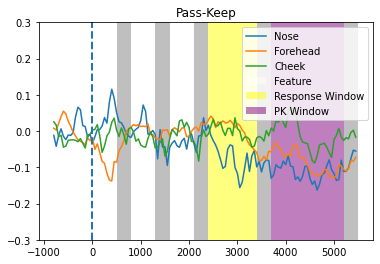

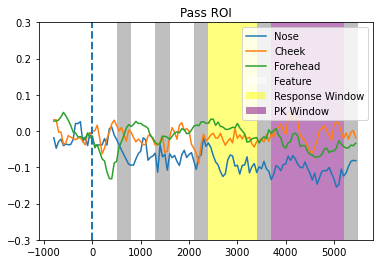

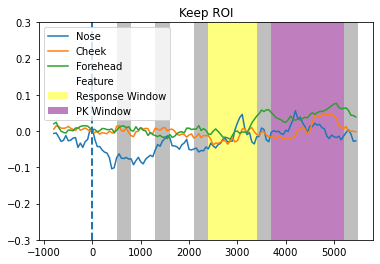

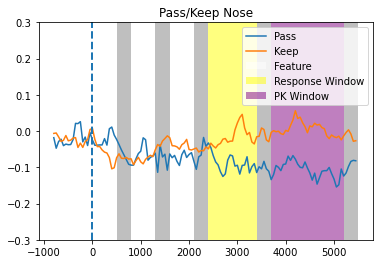

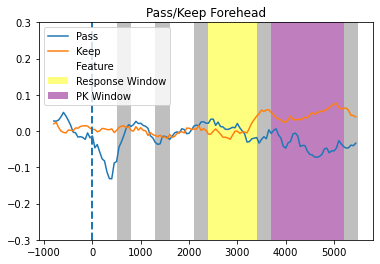

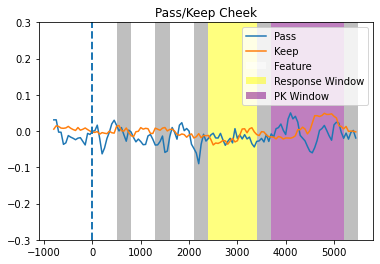

In [12]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

Nose


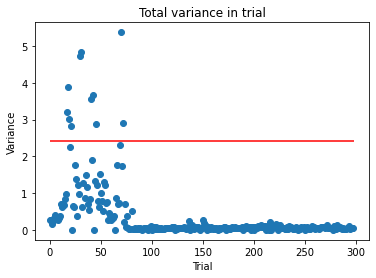

Forehead


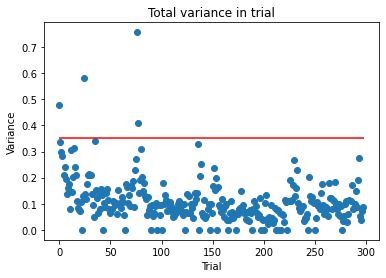

Cheek


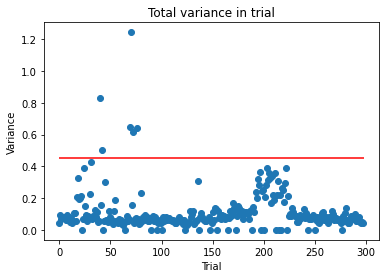

(197, 140)
(197,)
(63, 140)
(63,)
(197, 140)
(197,)
(63, 140)
(63,)
(197, 140)
(197,)
(63, 140)
(63,)


In [13]:
## outlier remove -> split condition -> baseline

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(np.array(full_nose_roi_data),mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(np.array(full_forehead_roi_data),mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(np.array(full_cheek_roi_data),mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(300) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
nose_roi_data_outlier_removed = removeOutlier(np.array(full_nose_roi_data), invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
forehead_roi_data_outlier_removed = removeOutlier(np.array(full_forehead_roi_data), invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
cheek_roi_data_outlier_removed = removeOutlier(np.array(full_cheek_roi_data), invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)
## split condition
# nose
keepNose = nose_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passNose = nose_roi_data_outlier_removed[np.where(validPk == 0)[0],:]
# forehead
keepForehead = forehead_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passForehead = forehead_roi_data_outlier_removed[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheek_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passCheek = cheek_roi_data_outlier_removed[np.where(validPk == 0)[0],:]

# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


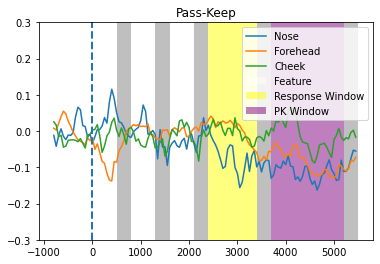

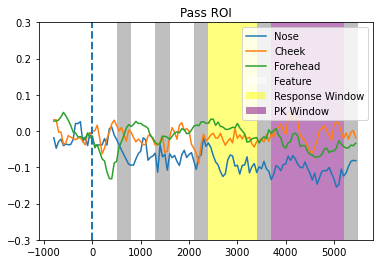

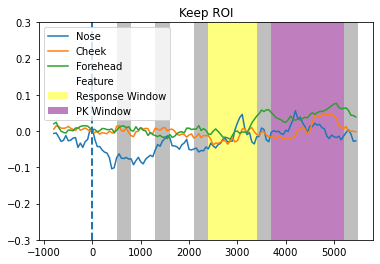

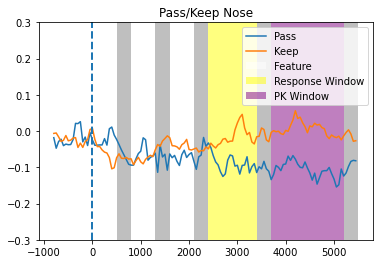

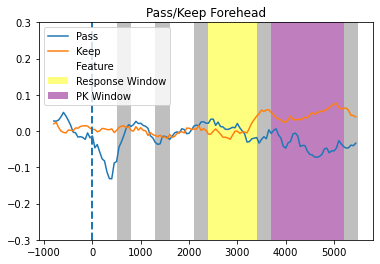

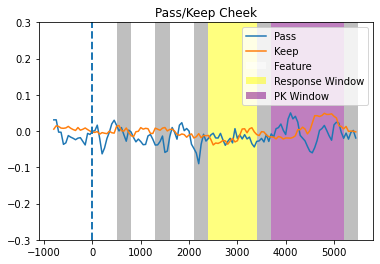

In [14]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [15]:
## split condition -> outlier remove -> baseline

## split condition
# nose
keepNose = np.array(full_nose_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passNose = np.array(full_nose_roi_data)[np.where(stimresponsechoice == 0)[0],:]
# forehead
keepForehead = np.array(full_forehead_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passForehead = np.array(full_forehead_roi_data)[np.where(stimresponsechoice == 0)[0],:]
# cheek
keepCheek = np.array(full_cheek_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passCheek = np.array(full_cheek_roi_data)[np.where(stimresponsechoice == 0)[0],:]



## outlier remove
maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,np.full(maskShape,False),varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,np.full(maskShape,False),varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,np.full(maskShape,False),varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier)))
validTrialInd = np.array([i for i in np.arange(maskShape) if i not in invalidTrials])
validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,np.full(maskShape,False),varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,np.full(maskShape,False),varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,np.full(maskShape,False),varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier)))
validTrialInd = np.array([i for i in np.arange(maskShape) if i not in invalidTrials])
validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]

# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


(197, 140)
(197,)
(62, 140)
(62,)
(197, 140)
(197,)
(62, 140)
(62,)
(197, 140)
(197,)
(62, 140)
(62,)


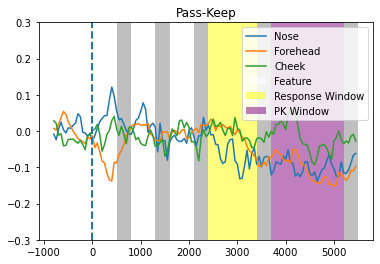

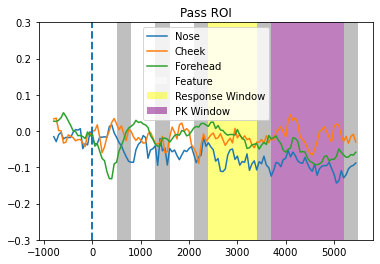

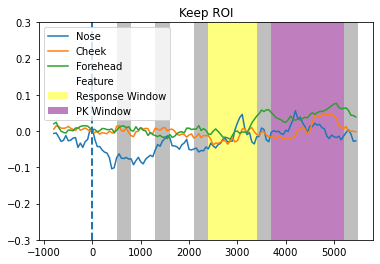

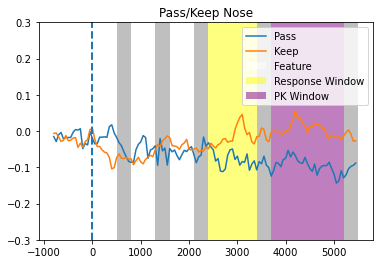

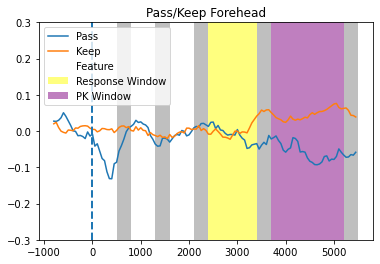

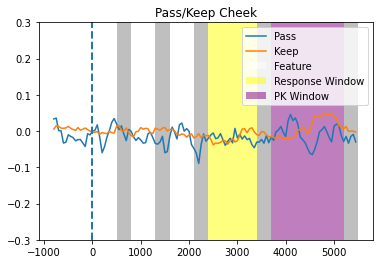

In [16]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [17]:
## split condition -> outlier remove -> baseline

## split condition
# nose
keepNose = np.array(keep_nose_roi_data)
passNose = np.array(pass_nose_roi_data)
# forehead
keepForehead = np.array(keep_forehead_roi_data)
passForehead = np.array(pass_forehead_roi_data)
# cheek
keepCheek = (np.array(keep_left_cheek_roi_data) + np.array(keep_right_cheek_roi_data))/2
passCheek = (np.array(pass_left_cheek_roi_data) + np.array(pass_right_cheek_roi_data))/2


keepEegBadTrials = np.array(keepEegBadTrials)
passEegBadTrials = np.array(passEegBadTrials)

## outlier remove
# maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,keepEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,keepEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,keepEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(keepEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(keepEegBadTrials.shape[0]) if i not in invalidTrials])
# validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

# maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,passEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,passEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,passEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(passEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(passEegBadTrials.shape[0]) if i not in invalidTrials])
# validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]



# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


(196, 148)
(196,)
(61, 215)
(61,)
(196, 148)
(196,)
(61, 215)
(61,)
(196, 148)
(196,)
(61, 215)
(61,)


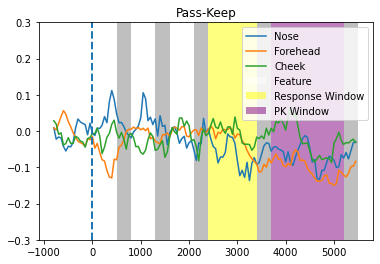

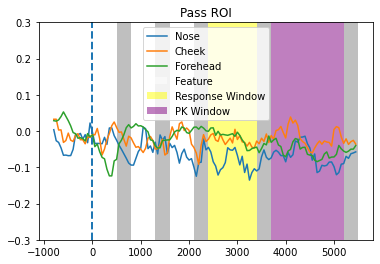

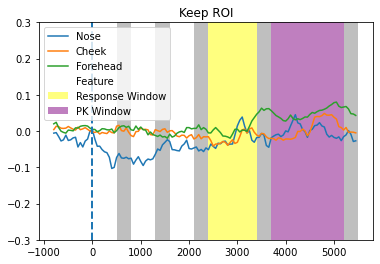

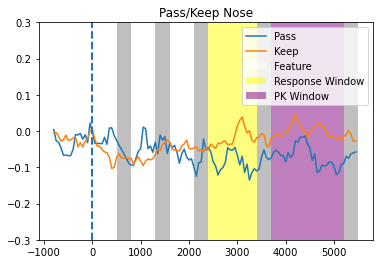

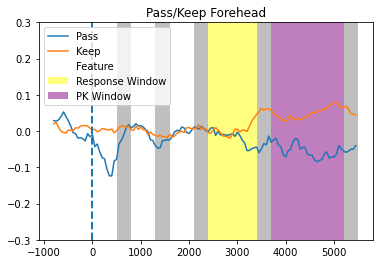

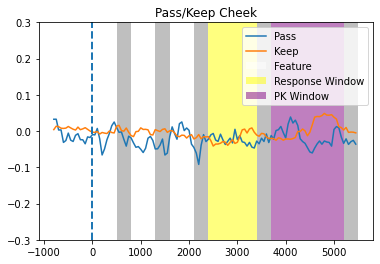

In [18]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

(298, 140)
(298,)
(298, 140)
(298,)
(298, 140)
(298,)
Nose


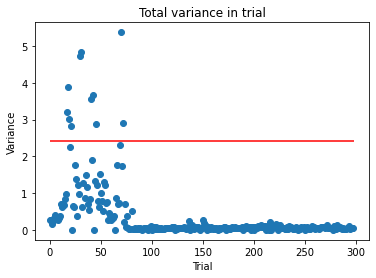

Forehead


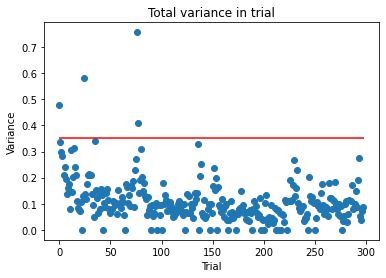

Cheek


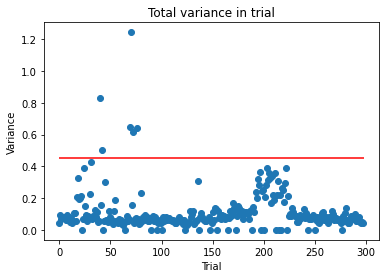

In [19]:
### baseline -> outlier remove -> split condition

## baseline
bsnose = baselinecorrect(np.array(full_nose_roi_data),range(20))
bsfore = baselinecorrect(np.array(full_forehead_roi_data),range(20))
bscheek = baselinecorrect(np.array(full_cheek_roi_data),range(20))

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(bsnose,mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(bsfore,mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(bscheek,mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(full_room_temp_data.shape[0]) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
bsnose = removeOutlier(bsnose, invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
bsfore = removeOutlier(bsfore, invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
bscheek = removeOutlier(bscheek, invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
noseTrials = np.round(bsnose, 2)
foreheadTrials = np.round(bsfore, 2)
cheekTrials = np.round(bscheek,2)

## split condition
# nose
keepNose = noseTrials[np.where(validPk == 1)[0],:]
passNose = noseTrials[np.where(validPk == 0)[0],:]
# forehead
keepForehead = foreheadTrials[np.where(validPk == 1)[0],:]
passForehead = foreheadTrials[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheekTrials[np.where(validPk == 1)[0],:]
passCheek = cheekTrials[np.where(validPk == 0)[0],:]



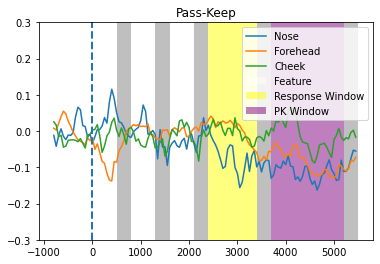

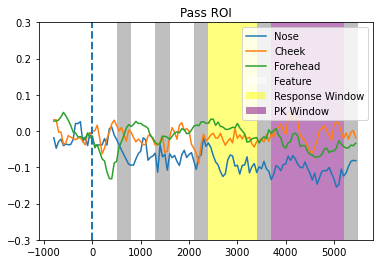

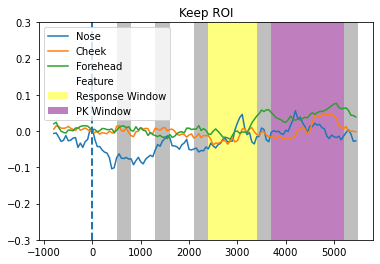

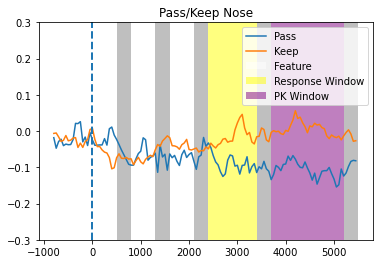

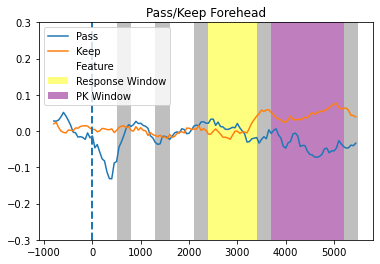

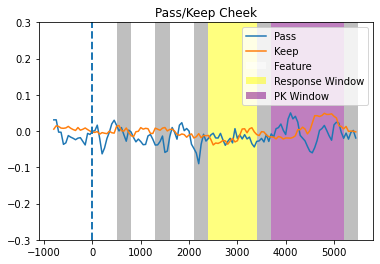

In [20]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [21]:
### baseline -> split condition -> outlier remove 

## baseline
bsnose = baselinecorrect(np.array(full_nose_roi_data),range(20))
bsfore = baselinecorrect(np.array(full_forehead_roi_data),range(20))
bscheek = baselinecorrect(np.array(full_cheek_roi_data),range(20))

## split condition
# nose
keepNose = bsnose[np.where(stimresponsechoice == 1)[0],:]
passNose = bsnose[np.where(stimresponsechoice == 0)[0],:]
# forehead
keepForehead = bsfore[np.where(stimresponsechoice == 1)[0],:]
passForehead = bsfore[np.where(stimresponsechoice == 0)[0],:]
# cheek
keepCheek = bscheek[np.where(stimresponsechoice == 1)[0],:]
passCheek = bscheek[np.where(stimresponsechoice == 0)[0],:]


## outlier remove
## outlier remove
# maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,keepEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,keepEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,keepEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(keepEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(keepEegBadTrials.shape[0]) if i not in invalidTrials])
# validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

# maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,passEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,passEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,passEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(passEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(passEegBadTrials.shape[0]) if i not in invalidTrials])
# validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]



# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)



# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)





(298, 140)
(298,)
(298, 140)
(298,)
(298, 140)
(298,)


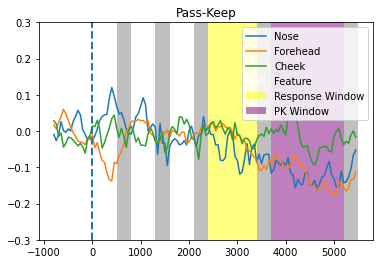

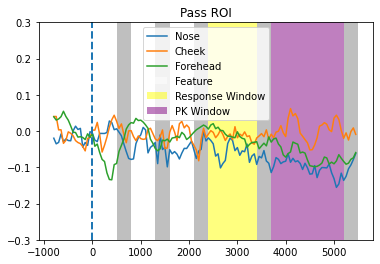

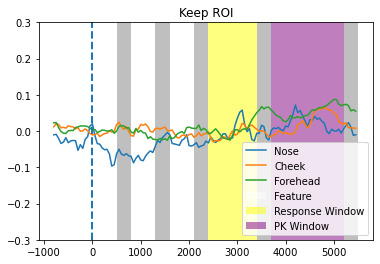

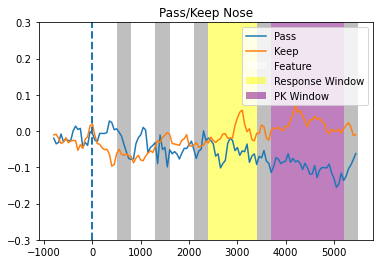

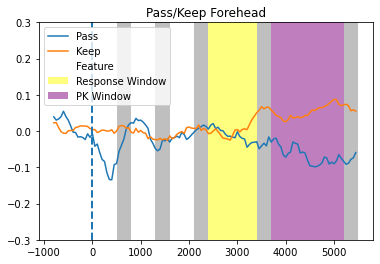

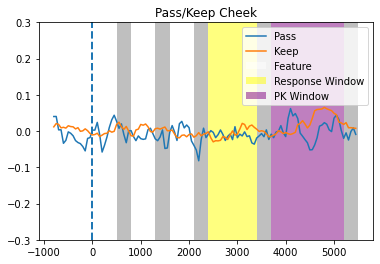

In [22]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [23]:
from hdf5storage import savemat
outdict = {}
outdict['processed_pass_nose'] = passNose
outdict['processed_pass_forehead'] = passForehead
outdict['processed_pass_cheek'] = passCheek
# outdict['processed_pass_right_cheek'] = passRight
outdict['processed_keep_nose'] = keepNose
outdict['processed_keep_forehead'] = keepForehead
outdict['processed_keep_cheek'] = keepCheek
# outdict['processed_keep_right_cheek'] = keepRight
outdict['keep_invalid_trials'] = keepEegBadTrials
outdict['pass_invalid_trials'] = passEegBadTrials
# outdict['keep_trial_ind'] = validKeepTrialInd 
# outdict['pass_trial_ind'] = validPassTrialInd
outdict['full_nose_data'] = full_nose_roi_data
outdict['full_bridge_data'] = full_bridge_roi_data
outdict['full_forehead_data'] = full_forehead_roi_data
outdict['full_left_cheek_data'] = full_left_cheek_roi_data
outdict['full_right_cheek_data'] = full_right_cheek_roi_data
outdict['full_cheek_data'] = full_cheek_roi_data
outdict['full_room_temp_data'] = full_room_temp_data
outdict['pass_nose_data'] = pass_nose_roi_data
outdict['pass_bridge_data'] = pass_bridge_roi_data
outdict['pass_forehead_data'] = pass_forehead_roi_data
outdict['pass_left_cheek_data'] = pass_left_cheek_roi_data
outdict['pass_right_cheek_data'] = pass_right_cheek_roi_data
outdict['pass_room_temp_data'] = pass_room_temp_data
outdict['keep_nose_data'] = keep_nose_roi_data
outdict['keep_bridge_data'] = keep_bridge_roi_data
outdict['keep_forehead_data'] = keep_forehead_roi_data
outdict['keep_left_cheek_data'] = keep_left_cheek_roi_data
outdict['keep_right_cheek_data'] = keep_right_cheek_roi_data
outdict['keep_room_temp_data'] = keep_room_temp_data
outpath = f'../data/Subject{sub}/{sub}Session{ses}/Subject{sub}_roi_data2.hdf'
savemat(outpath,outdict,store_python_metadata=True)